In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import LS_modular
import bls_modular
import seaborn as sns


 The goal of this notebook is to use RF to remove non-periodic targets, only uses 2 classes
======

## Useful functions ---------------------------

In [9]:
# unique item finder

def uniquefinder(mylist):
    '''
    Function finds unique values within a list, also stats on occurance rates
    
    inputs: an array or list 
            (integers or strings)
    2 outputs: dictionary of occurances, list of unique values 
    '''
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('There are {} unique tics out of the original {}.'.format(uniques,len(mylist)),\
        '\nUse the first output dictionary', \
          'to see number of occurances for duplicates')
    return seen, uniq_tics


#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    '''
    inputs: a,b
            both lists or arrays
    outputs: not in b, not in a
            two lists
    '''
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a


def find_range(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)


def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return m.floor(n * multiplier) / multiplier


def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return m.ceil(n * multiplier) / multiplier


# based on training set
def label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    2==Complex = "clear periodicity but complicated by multiple spots or low signal to noise";
    3== EB = "eclipsing binaries"; 
    4==Binaries = "likely eclipsing binaries too"; 
    5==Flat = "no rotational modulation"
    '''
    mydictionary = {1:'Astrophysical Signal',3:'Likely Eclipsing Binary',5:'Flat',2:'nothing',4:'nothing'}
    return(mydictionary[label])

def abs_mag(m,D):
    '''
    ~converts apparent mag to absolute mag~
    args:
          m: apparent mag
          D: 1/parallax in parsecs
    RETURNS: absolute mag
    '''
    return m - 5*np.log10(D) + 5

def mas_to_parsec(mas):
    '''
    ~converts milliarcseconds(mas) to parsecs, useful b/c Gaia parallax in mas~
    args:
         mas: parallax measure in mas
    RETURNS: parallax in parsecs
    '''
    return mas * 1000

def get_D(parallax):
    '''
    ~converts parallax to distance~
    args:
        parrallax: parallax measure in mas
    RETURNS: distance
    '''
    plx = mas_to_parsec(parallax)
    return 1/plx

def slope(x1,x2,y1,y2):
    ''' 
    inputs: coordinates for 2 plotted datapoints
    returns: slope
    '''
    m = (y2 -y1) / (x2-x1)
    return (y2 -y1) / (x2-x1)

def get_b(m,x,y):
    '''
    gives y-intercept(b) for a straight line
    inputs: slope(m); point on line(x,y)
    returns: b
    '''
    b = -(m*x) + y
    return b

## Load Data ---------------------------

In [10]:
#my data to get RF results about
unseen = pd.read_csv('/Volumes/Seagate-stars/SECTORS/LSstats_ticcat_secs1415.csv') #unseen data

#for comparisons later
mqdata = pd.read_csv('data/mcquillan_sample.csv')

#training/testing examples from CVZ 
labels_data = ascii.read('data/master_bls_bigstats_stitchedlcs.fits')
labels = pd.read_csv('data/RF2_Classification_TICS_3.csv', header=4)
#training/testing examples from Sectors 14&15
morelabels = pd.read_csv('data/RF1-TrainingSet.csv')


In [11]:
## i should be using this for unseen data b/c it includes BLS stats -- "unseen" above does NOT

mytest = pd.read_csv('/Volumes/Seagate-stars/SECTORS/allstats_14_15.csv')
print(len(list(unseen.columns)),len(list(mytest.columns)))
list(mytest.columns)

133 138


['TIC',
 'period_bls',
 'power_bls',
 'depth_bls',
 'dur_bls',
 'tt_bls',
 'Sector',
 'rvar',
 'ls-1',
 'ls-2',
 'ls-3',
 'lsamp-1',
 'lsamp-2',
 'lsamp-3',
 'version',
 'HIP',
 'TYC',
 'UCAC',
 'TWOMASS',
 'SDSS',
 'ALLWISE',
 'GAIA',
 'APASS',
 'KIC',
 'objType',
 'typeSrc',
 'ra',
 'dec',
 'POSflag',
 'pmRA',
 'e_pmRA',
 'pmDEC',
 'e_pmDEC',
 'PMflag',
 'plx',
 'e_plx',
 'PARflag',
 'gallong',
 'gallat',
 'eclong',
 'eclat',
 'Bmag',
 'e_Bmag',
 'Vmag',
 'e_Vmag',
 'umag',
 'e_umag',
 'gmag',
 'e_gmag',
 'rmag',
 'e_rmag',
 'imag',
 'e_imag',
 'zmag',
 'e_zmag',
 'Jmag',
 'e_Jmag',
 'Hmag',
 'e_Hmag',
 'Kmag',
 'e_Kmag',
 'TWOMflag',
 'prox',
 'w1mag',
 'e_w1mag',
 'w2mag',
 'e_w2mag',
 'w3mag',
 'e_w3mag',
 'w4mag',
 'e_w4mag',
 'GAIAmag',
 'e_GAIAmag',
 'Tmag',
 'e_Tmag',
 'TESSflag',
 'SPFlag',
 'Teff',
 'e_Teff',
 'logg',
 'e_logg',
 'MH',
 'e_MH',
 'rad',
 'e_rad',
 'mass',
 'e_mass',
 'rho',
 'e_rho',
 'lumclass',
 'lum',
 'e_lum',
 'd',
 'e_d',
 'ebv',
 'e_ebv',
 'numcont',
 

## Format features/labels & unseen data ---------------------------

In [12]:
# do some cuts/renaming to CVZ training set 

#make formats match
labels_data_df = labels_data.to_pandas()
#rename column for matching ease
labels_data_df = labels_data_df.rename(columns={"ID": 'TIC'})
#match CVZ labels into one df
features = pd.merge(labels_data_df, labels, on='TIC')#lose 7 here but its ok, proceed
#drop high teff CVZ examples
features = features[features['Teff']<=6500] #lost 43 here but its ok, proceed
#only keep CVZ periodic(1) or flat(5) labels
features = features[(features['CLASS']==1) | (features['CLASS']==5)] #lost 114 here (approx 2:1 per/flat) but its ok, proceed

features

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarnin

,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,power,period,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments
10,32150630,12,0.057739,1.485555,0.745751,1.494213,0.452719,0.104419,0.077054,1.491668,...,1295,1.492110,0.006370,0.448,0.16,1,1.0,1.0,0.0,# acf2 is a double harmonic; also these rps ar...
14,38907305,13,0.004499,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,0.780556,...,48697,19.505230,0.007053,17.776,0.16,5,NaN,NaN,NaN,NaN
19,139371600,13,0.004312,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,0.069445,...,23436,9.905858,0.000049,8.816,0.16,1,1.0,0.0,1.0,# acf2 differs by ~0.2
20,140579537,13,0.011740,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,0.069445,...,38979,15.812316,0.000201,15.520,0.16,1,1.0,0.0,0.0,NaN
21,140579674,13,0.015263,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,0.069445,...,47554,19.070881,0.000289,18.816,0.16,1,0.0,0.0,0.0,"# ls2 is correct, acf2 is a double harmonic"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,349152048,12,0.014203,0.667290,0.665706,0.675185,0.599031,0.098220,0.039032,0.669445,...,33145,13.595352,0.000076,2.528,0.16,1,1.0,1.0,0.0,# acf2 is a double harmonic; this is def a BEATS
320,349154435,13,0.014492,4.547054,2.216561,4.635532,0.060046,0.018639,0.014601,13.297233,...,9032,4.432229,0.009053,3.008,0.16,1,1.0,0.0,0.0,# acf2 is a double harmonic; also rp is 2 plan...
330,358510596,10,0.002464,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,0.069445,...,48910,19.586172,0.000076,13.952,0.16,1,1.0,0.0,1.0,# ls1 & acf2 only off by ~0.1
337,404768019,12,0.056316,0.722297,0.719017,0.725462,0.506582,0.136337,0.124000,0.720834,...,1170,1.444609,0.000082,0.480,0.16,1,1.0,1.0,0.0,"#acf2 is a double harmonic, ls-2 could also be..."


### _Can add in extra training examples here_

In [13]:
#############################################################################
#############################################################################
####### test w & w/o these EXTRA TRAINING EXAMPLES from sectors 14 & 15
#############################################################################
#############################################################################

#this one line not really necessary - but makes df easier to read by pulling relevant columns
morelabels = morelabels[['Periodic','P_sector','Non-periodic','NP_sector']]
#pull columns & remove nans
sec1415_tics_p = morelabels['Periodic'].to_numpy()[~np.isnan(morelabels['Periodic'].to_numpy())] 
sec1415_tics_np = morelabels['Non-periodic'].to_numpy()[~np.isnan(morelabels['Non-periodic'].to_numpy())]
sec1415_secs_p = morelabels['P_sector'].to_numpy()[~np.isnan(morelabels['P_sector'].to_numpy())]
sec1415_secs_np = morelabels['NP_sector'].to_numpy()[~np.isnan(morelabels['NP_sector'].to_numpy())]
#generate labels
periodics_label_list = np.repeat(1,len(sec1415_tics_p))
nonperiodics_label_list = np.repeat(5,len(sec1415_tics_np))
#combine columns
sec1415_labels = np.append(periodics_label_list, nonperiodics_label_list)
sec1415_tics = np.append(sec1415_tics_p, sec1415_tics_np)
sec1415_secs = np.append(sec1415_secs_p, sec1415_secs_np)

#put into new df
sec1415_info = {'TIC': sec1415_tics, 'Sector': sec1415_secs, 'CLASS': sec1415_labels}
extralabels_1 = pd.DataFrame(sec1415_info)
#merge these examples with their data 
extralabels_2 = pd.merge(unseen, extralabels_1, on=['TIC','Sector'])
#rename some columns to match features
extralabels_3 = extralabels_2.rename(columns={"ls-1": 'ls1','ls-2':'ls2','ls-3':'ls3','lsamp-1':'lsamp1',
                                         'lsamp-2':'lsamp2','lsamp-3':'lsamp3'})



print('Before merge length:',len(features))
#merge with CVZ features 
features = pd.concat([features, extralabels_3])

#do a teff cut to match desired range
features = features[features['Teff']<=6500]
#do another cut if dont have necessary data to be sure on MS
step1 = features[pd.notna(features['plx']).to_numpy()]
step2 = step1[pd.notna(step1['GAIAmag'].to_numpy())]
features = step2[pd.notna(step2['Teff'].to_numpy())]

features

Before merge length: 183


,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,period,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments,Sector
14,38907305,13.0,0.004499,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,0.780556,...,19.505230,0.007053,17.776,0.16,5,NaN,NaN,NaN,NaN,NaN
19,139371600,13.0,0.004312,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,0.069445,...,9.905858,0.000049,8.816,0.16,1,1.0,0.0,1.0,# acf2 differs by ~0.2,NaN
20,140579537,13.0,0.011740,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,0.069445,...,15.812316,0.000201,15.520,0.16,1,1.0,0.0,0.0,NaN,NaN
21,140579674,13.0,0.015263,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,0.069445,...,19.070881,0.000289,18.816,0.16,1,0.0,0.0,0.0,"# ls2 is correct, acf2 is a double harmonic",NaN
22,140580497,13.0,0.014146,10.264962,9.369888,10.688587,0.000516,0.000505,0.000330,0.069445,...,13.421308,0.000404,4.192,0.16,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,230077650,NaN,2942.876562,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0
73,230085290,NaN,3277.640625,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0
74,47579336,NaN,12540.856250,3.864723,3.121786,5.063066,0.973883,0.222684,0.219672,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0
75,53569838,NaN,5909.745313,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,NaN,...,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0


### _Keep only Main Sequence stars_

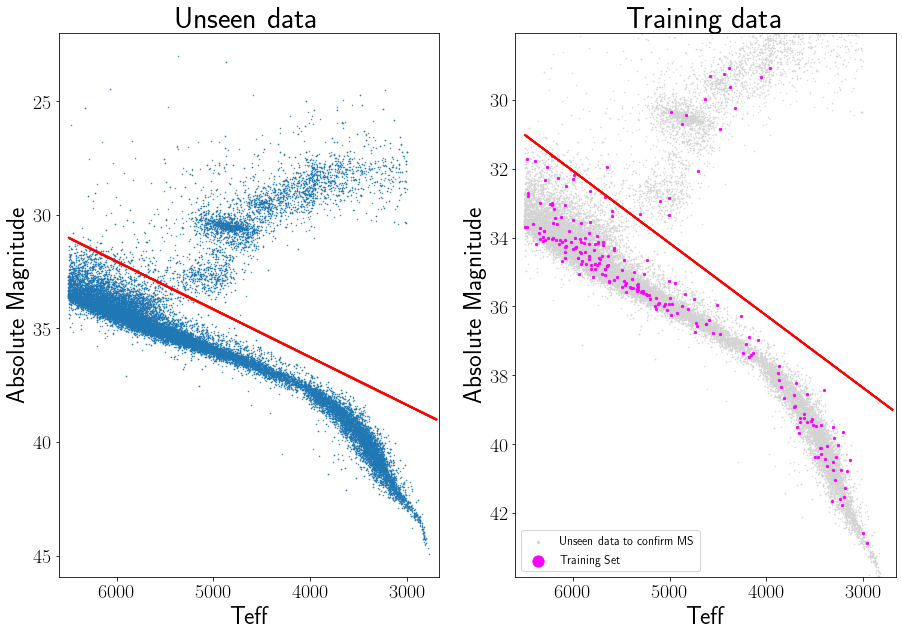

In [14]:
## add Abs_Mag column & find division line ---to remove giants from unseen & training data

## for unseen
u_abs_GAIAmag = []
u_teffs =[]
for plx,mag,temp in unseen[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    u_abs_GAIAmag.append(newmag)
    u_teffs.append(temp)
#add to df
unseen['GAIA_AbsMag'] = u_abs_GAIAmag
    
## for training
t_abs_GAIAmag = []
t_teffs =[]
for plx,mag,temp in features[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    t_abs_GAIAmag.append(newmag)
    t_teffs.append(temp)
#add to df
features['GAIA_AbsMag'] = t_abs_GAIAmag


################note that red line is the SAME on both plots to ensure training & predicitions share same parameter space
## for unseen
#determine division line params
u_pt1 = [6500,31]
u_pt2 = [2700,39]
u_m = slope(u_pt1[0],u_pt2[0],u_pt1[1],u_pt2[1])
u_b = get_b(u_m,u_pt1[0],u_pt1[1])
#create arrays for line
u_xarr = np.arange(u_pt2[0],u_pt1[0],1)
u_yarr = [u_m*x + u_b for x in u_xarr]
## for training
#determine division line params
t_pt1 = [6500,31]
t_pt2 = [2700,39]
t_m = slope(t_pt1[0],t_pt2[0],t_pt1[1],t_pt2[1])
t_b = get_b(t_m,t_pt1[0],t_pt1[1])
#create arrays for line
t_xarr = np.arange(t_pt2[0],t_pt1[0],1)
t_yarr = [t_m*x + t_b for x in t_xarr]
    
## plot them
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.scatter(u_teffs,u_abs_GAIAmag,s=.2)
ax1.scatter(u_xarr,u_yarr,color='r',s=.2)
ax1.set_ylabel('Absolute Magnitude');ax1.set_xlabel('Teff');
ax1.set_xlim(max(u_teffs)+100,min(u_teffs)-100)
ax1.set_title('Unseen data',fontsize=30);
ax1.set_ylim(max(u_abs_GAIAmag)+1,min(u_abs_GAIAmag)-1);

ax2.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS',color='lightgrey')
ax2.scatter(t_teffs,t_abs_GAIAmag,s=5,label='Training Set',color='magenta')
ax2.scatter(t_xarr,t_yarr,color='r',s=.2)
ax2.legend(fontsize='large',markerscale=5)
ax2.set_ylabel('Absolute Magnitude');ax2.set_xlabel('Teff');
ax2.set_xlim(max(t_teffs)+100,min(t_teffs)-300)
ax2.set_ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
ax2.set_title('Training data',fontsize=30);



For training examples use: 
------------------ 
"features_nogiants" 
 
For unseen data use: 
------------------ 
"unseen_nogiants"


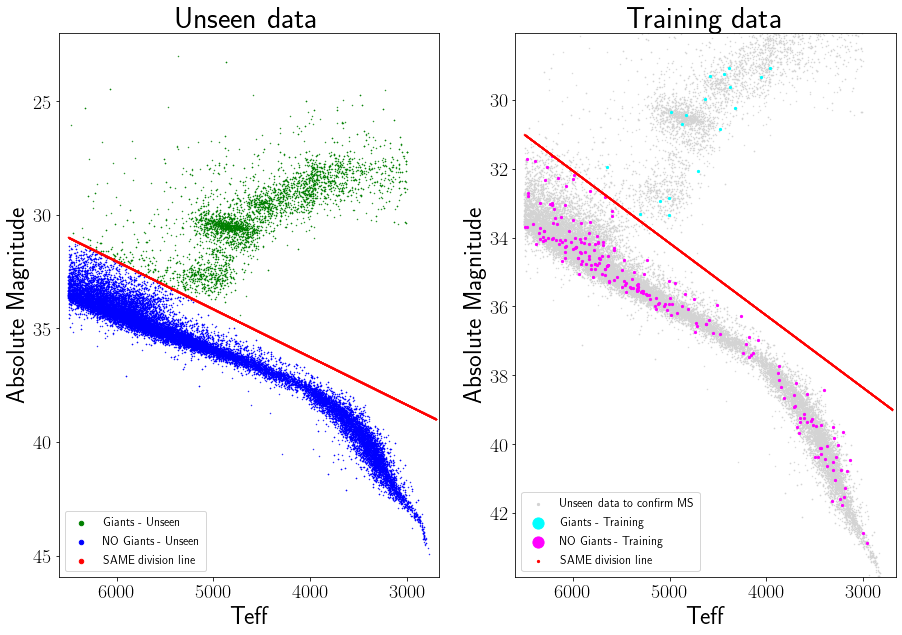

In [15]:
## remove giants & replot to confirm

#do cut for unseen
compare_values = [u_m*x + u_b for x in unseen['Teff'].to_numpy()] #ABSmagnitude value on the red line at star's teff
unseen_nogiants = unseen[[unseen['GAIA_AbsMag'].to_numpy()[i] > compare_values[i] for i in range(len(compare_values))]]
unseen_giantsonly = unseen[[unseen['GAIA_AbsMag'].to_numpy()[i] <= compare_values[i] for i in range(len(compare_values))]]

#do cut for features
compare_values = [t_m*x + t_b for x in features['Teff'].to_numpy()] #ABSmagnitude value on the red line at star's teff
features_nogiants = features[[features['GAIA_AbsMag'].to_numpy()[i] > compare_values[i] for i in range(len(compare_values))]]
features_giantsonly = features[[features['GAIA_AbsMag'].to_numpy()[i] <= compare_values[i] for i in range(len(compare_values))]]
######## note that both "compare_values" are the SAME


#plot to verify cut
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
ax1.scatter(unseen_giantsonly['Teff'].to_numpy(),unseen_giantsonly['GAIA_AbsMag'].to_numpy(),s=.2,color='g',label='Giants - Unseen')
ax1.scatter(unseen_nogiants['Teff'].to_numpy(),unseen_nogiants['GAIA_AbsMag'].to_numpy(),s=.2,color='b',label='NO Giants - Unseen')
ax1.scatter(u_xarr,u_yarr,color='r',s=.2,label='SAME division line')
ax1.legend(fontsize='large',markerscale=10)
ax1.set_ylabel('Absolute Magnitude');ax1.set_xlabel('Teff');
ax1.set_xlim(max(u_teffs)+100,min(u_teffs)-100)
ax1.set_title('Unseen data',fontsize=30);
ax1.set_ylim(max(u_abs_GAIAmag)+1,min(u_abs_GAIAmag)-1);

ax2.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS',color='lightgrey')
ax2.scatter(features_giantsonly['Teff'].to_numpy(),features_giantsonly['GAIA_AbsMag'].to_numpy(),s=5,label='Giants - Training',color='cyan')
ax2.scatter(features_nogiants['Teff'].to_numpy(),features_nogiants['GAIA_AbsMag'].to_numpy(),s=5,label='NO Giants - Training',color='magenta')
ax2.scatter(t_xarr,t_yarr,color='r',s=.2,label='SAME division line')
ax2.legend(fontsize='large',markerscale=5)
ax2.set_ylabel('Absolute Magnitude');ax2.set_xlabel('Teff');
ax2.set_xlim(max(t_teffs)+100,min(t_teffs)-300)
ax2.set_ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
ax2.set_title('Training data',fontsize=30);

print('For training examples use: \n------------------ \n"features_nogiants" \n \nFor unseen data use: \n------------------ \n"unseen_nogiants"')

### _Decide Features to Use_

In [16]:
#check totals to see where the nans are

nan_features_lists = ['TOTsecs',
                    'period','depth','transit_time','duration',
                      'LS_correct','ACF_correct','ACF2_correct','Sector', '#comments'
                     'acf1','acf2',]
print(list(features.columns))
features.describe(include='all') #arg to get all columns to show-except it isnt working FUN!

['TIC', 'TOTsecs', 'rvar', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'acf1', 'acf2', 'acf3', 'acfamp1', 'acfamp2', 'acfamp3', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'objType', 'typeSrc', 'ra', 'dec', 'POSflag', 'pmRA', 'e_pmRA', 'pmDEC', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'Tmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'eneg_EBV', 'epos_EBV', 'EBVflag', 'eneg_Mass', 'e

,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments,Sector,GAIA_AbsMag
count,2.440000e+02,167.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,167.000000,...,167.000000,167.000000,1.670000e+02,244.000000,103.000000,103.000000,103.000000,71,77.000000,244.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,# acf2 is a double harmonic,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN
mean,1.383793e+08,11.886228,1113.422466,7.190644,6.703133,5.958475,0.212301,0.076782,0.043732,0.786486,...,0.001559,6.327613,1.600000e-01,2.442623,0.757282,0.203883,0.495146,NaN,14.272727,35.453826
std,6.699256e+07,0.860227,4396.345601,6.903762,5.880234,5.681105,0.281670,0.098619,0.052486,2.853505,...,0.014013,5.256822,1.113562e-16,1.924711,0.430823,0.404853,0.502421,NaN,0.448282,2.729533
min,1.589229e+07,10.000000,0.000562,0.501684,0.500644,0.502642,0.000213,0.000179,0.000178,0.038889,...,0.000007,0.001870,1.600000e-01,1.000000,0.000000,0.000000,0.000000,NaN,14.000000,29.063986
25%,1.405990e+08,11.000000,0.005442,3.231806,2.946101,2.811795,0.003759,0.002207,0.002005,0.069445,...,0.000057,1.712000,1.600000e-01,1.000000,1.000000,0.000000,0.000000,NaN,14.000000,34.023322
50%,1.418617e+08,12.000000,0.014552,5.569540,5.444304,4.758256,0.061252,0.029487,0.017995,0.069445,...,0.000125,4.976000,1.600000e-01,1.000000,1.000000,0.000000,0.000000,NaN,14.000000,34.921991
75%,1.596139e+08,12.000000,29.970070,9.204549,8.715437,6.698359,0.378334,0.120620,0.076954,0.070833,...,0.000263,10.216000,1.600000e-01,5.000000,1.000000,0.000000,1.000000,NaN,15.000000,36.500925


In [17]:
#finalize list of features used

features_list = ['TIC','rvar','Teff',
                 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3',
                 'Vmag','Tmag','CLASS']
#would like to use these BUT would cause a reduction in my training sample due to nans
extra_features_list = ['logg','Bmag'] #have nans

########################################################
## merge here if want to add features to features_lists 
# added_feature = ['mytest']
# features_list = features_list + added_feature
########################################################

#select features
short_features = features[features_list]
#remove any nans in the final features
short_features = short_features.dropna()


#check final distribution for possible problems
short_features.describe(include='all')

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,CLASS
count,2.440000e+02,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,1.383793e+08,1113.422466,5114.419508,7.190644,6.703133,5.958475,0.212301,0.076782,0.043732,11.094874,10.062600,2.442623
std,6.699256e+07,4396.345601,1002.351409,6.903762,5.880234,5.681105,0.281670,0.098619,0.052486,2.626286,2.119667,1.924711
min,1.589229e+07,0.000562,2967.000000,0.501684,0.500644,0.502642,0.000213,0.000179,0.000178,4.009980,3.518000,1.000000
25%,1.405990e+08,0.005442,4385.000000,3.231806,2.946101,2.811795,0.003759,0.002207,0.002005,9.529000,8.792000,1.000000
50%,1.418617e+08,0.014552,5381.500000,5.569540,5.444304,4.758256,0.061252,0.029487,0.017995,10.884000,10.269800,1.000000
75%,1.596139e+08,29.970070,5914.250000,9.204549,8.715437,6.698359,0.378334,0.120620,0.076954,12.184250,11.237000,5.000000
max,4.047680e+08,52346.624707,6494.000000,49.558430,42.797165,46.673108,0.993360,0.524464,0.249504,17.460000,15.087900,5.000000


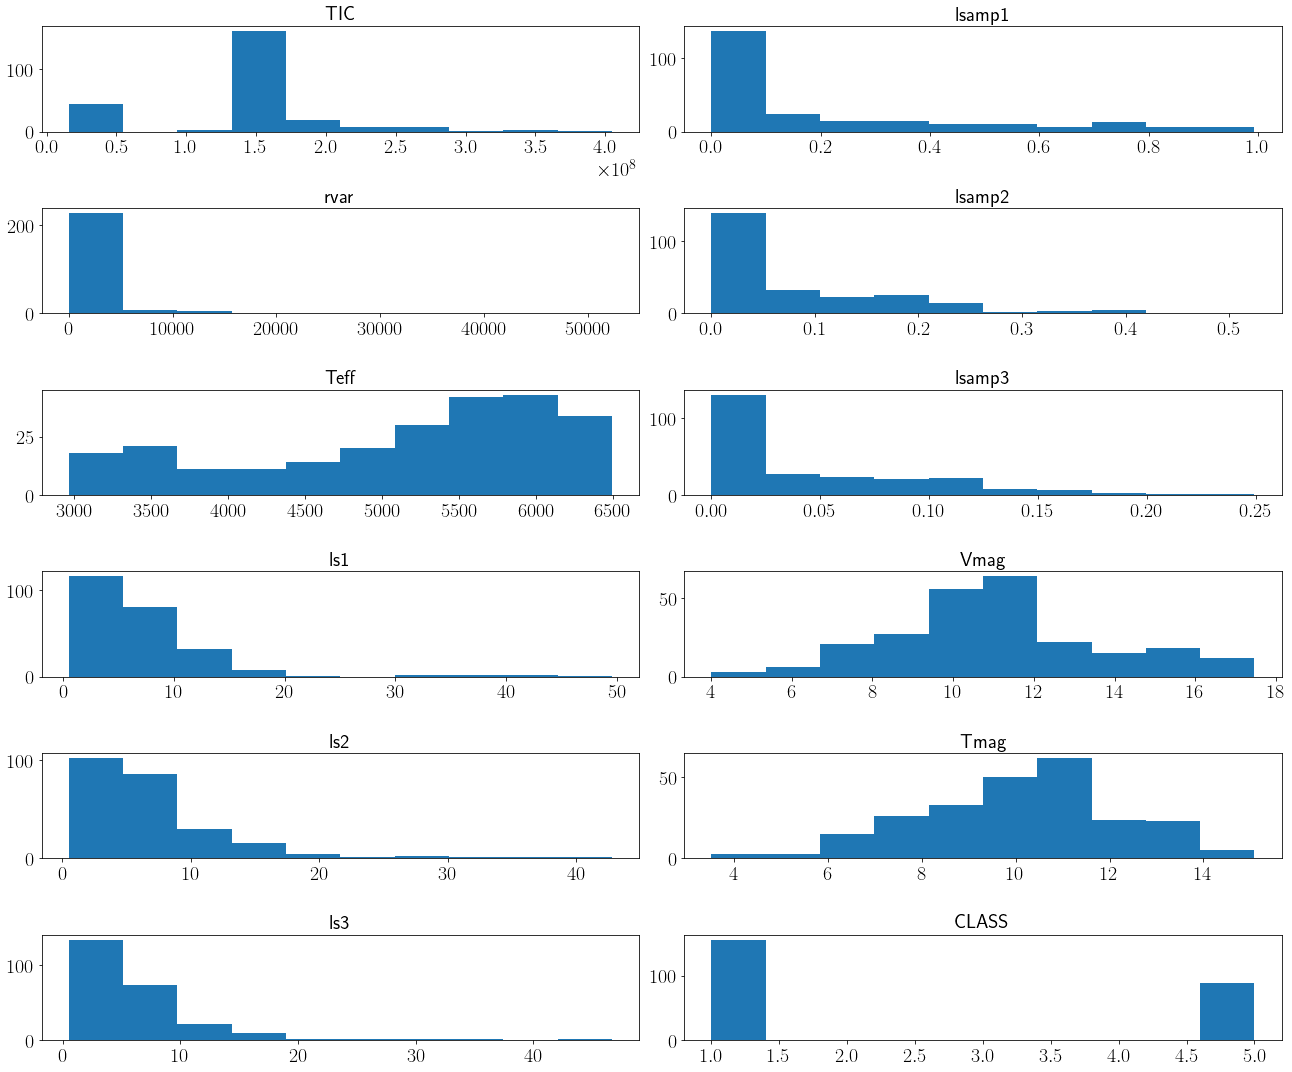

In [18]:
# explore distribution of training examples
f, ax = plt.subplots(6,2,figsize=(18,15))
for count,col in enumerate(list(short_features.columns)):
    
    if count <6: #count % 2 ==False: #even
        ax[count,0].hist(short_features[col])
        ax[count,0].set_title(col,fontsize=20)
    else: #odd
        ax[count-6,1].hist(short_features[col])
        ax[count-6,1].set_title(col,fontsize=20)
plt.tight_layout()

In [19]:
## inject random number as feature
np.random.seed(seed = 11)
short_features['random'] = np.random.random(size = len(short_features))
short_features

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,CLASS,random
14,38907305,0.004499,6193.00,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,11.04400,10.5022,5,0.180270
19,139371600,0.004312,6200.91,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,10.85700,10.3514,1,0.019475
20,140579537,0.011740,5578.00,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,12.04500,11.0732,1,0.463219
21,140579674,0.015263,5119.00,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,11.79700,11.1707,1,0.724934
22,140580497,0.014146,3471.00,10.264962,9.369888,10.688587,0.000516,0.000505,0.000330,14.59900,12.3873,5,0.420204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,230077650,2942.876562,6146.24,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,7.52000,7.0145,1,0.433992
73,230085290,3277.640625,5767.89,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,7.11438,6.5192,1,0.937504
74,47579336,12540.856250,4622.00,3.864723,3.121786,5.063066,0.973883,0.222684,0.219672,8.20000,6.8137,1,0.300661
75,53569838,5909.745313,5212.00,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,8.14000,7.4514,1,0.593216


In [20]:
#print final info

#split training labels from data
final_labels = short_features['CLASS'].to_numpy()
final_features = short_features.drop(columns=['CLASS'])
# print('verify these match {} = {}\n'.format(len(final_labels),len(final_features)))

# print final number of training examples and which features used
print('{} Features Used. \nThey are {}'.format(len(final_features.columns),list(final_features.columns)))
print('{} Training Examples Used.'.format(len(final_features)))
print('\n------------------------------- \nUse "final_labels" & "final_features"')

12 Features Used. 
They are ['TIC', 'rvar', 'Teff', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2', 'lsamp3', 'Vmag', 'Tmag', 'random']
244 Training Examples Used.

------------------------------- 
Use "final_labels" & "final_features"


## Build, train, test RF classifier-----------------------------

In [21]:
#set variable for feature data
X = final_features.reset_index(drop=True)
#set variable for correct labels
y = final_labels
#split data into test and training set
X_train, test_X, y_train, test_y = train_test_split(X, y, random_state = 11)

In [22]:
######play with parms here to get better model


#define random forest model
rf_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_jobs=-1, oob_score=True, random_state=11)

In [23]:
# print accuracy scores
print('Test Set Accuracy:',rf_model.score(test_X,test_y))  
print('Training Set Accuracy:', rf_model.score(X_train,y_train))
print('Out of the Box Accuracy:',rf_model.oob_score_)

Test Set Accuracy: 0.8360655737704918
Training Set Accuracy: 0.994535519125683
Out of the Box Accuracy: 0.9672131147540983


In [24]:
X

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,random
0,38907305,0.004499,6193.00,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,11.04400,10.5022,0.180270
1,139371600,0.004312,6200.91,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,10.85700,10.3514,0.019475
2,140579537,0.011740,5578.00,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,12.04500,11.0732,0.463219
3,140579674,0.015263,5119.00,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,11.79700,11.1707,0.724934
4,140580497,0.014146,3471.00,10.264962,9.369888,10.688587,0.000516,0.000505,0.000330,14.59900,12.3873,0.420204
...,...,...,...,...,...,...,...,...,...,...,...,...
239,230077650,2942.876562,6146.24,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,7.52000,7.0145,0.433992
240,230085290,3277.640625,5767.89,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,7.11438,6.5192,0.937504
241,47579336,12540.856250,4622.00,3.864723,3.121786,5.063066,0.973883,0.222684,0.219672,8.20000,6.8137,0.300661
242,53569838,5909.745313,5212.00,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,8.14000,7.4514,0.593216


## Cross Validation - leave one out

In [25]:
#set variable for feature data
X_CV = final_features.reset_index(drop=True)
#set variable for correct labels
y_CV = final_labels



#input: features,labels
# divide data to train(80),test(19),validate(1)
CVpredictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(range(len(X_CV))):
    ##get validation set
    loo_x = X_CV.iloc[idx]
    loo_y = y_CV[idx]
    ##remove validation data from features/labels
    x_after_loo = X_CV.drop(index = idx)
    y_after_loo = np.delete(y_CV, idx)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf_model_CV = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf_model_CV.fit(x_train_cv, y_train_cv)
    ##make loo into a df b/c model is picky b/c its only one example
    mydic = {'TIC':loo_x['TIC'],'rvar':loo_x['rvar'],'ls1':loo_x['ls1'],'ls2':loo_x['ls2'],
            'ls3':loo_x['ls3'],'lsamp1':loo_x['lsamp1'],'lsamp2':loo_x['lsamp2'],'lsamp3':loo_x['lsamp3'],
            'Vmag':loo_x['Vmag'],'Tmag':loo_x['Tmag'],'Teff':loo_x['Teff'],'random':loo_x['random']}
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf_model_CV.predict(loo_x_df) 
    ##save predictions
    CVpredictions.append(validation_prediction[0])
    
##add to df
X_CV['prediction'] = CVpredictions
X_CV['truth'] = y_CV
X_CV

,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,random,prediction,truth
0,38907305,0.004499,6193.00,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,11.04400,10.5022,0.180270,1,5
1,139371600,0.004312,6200.91,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,10.85700,10.3514,0.019475,1,1
2,140579537,0.011740,5578.00,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,12.04500,11.0732,0.463219,1,1
3,140579674,0.015263,5119.00,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,11.79700,11.1707,0.724934,1,1
4,140580497,0.014146,3471.00,10.264962,9.369888,10.688587,0.000516,0.000505,0.000330,14.59900,12.3873,0.420204,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,230077650,2942.876562,6146.24,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,7.52000,7.0145,0.433992,1,1
240,230085290,3277.640625,5767.89,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,7.11438,6.5192,0.937504,1,1
241,47579336,12540.856250,4622.00,3.864723,3.121786,5.063066,0.973883,0.222684,0.219672,8.20000,6.8137,0.300661,1,1
242,53569838,5909.745313,5212.00,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,8.14000,7.4514,0.593216,1,1


In [26]:
#CV_LOO accuracy
correct = 0
for count,val in enumerate(X_CV['prediction'].to_numpy()):
    truth = X_CV['truth'].iloc[count]
    if val == truth:
        correct += 1
    else:
        pass
    
print((correct/len(X_CV)) *100, 'accurate')

81.9672131147541 accurate


## Feature Importance ---------------------------------------

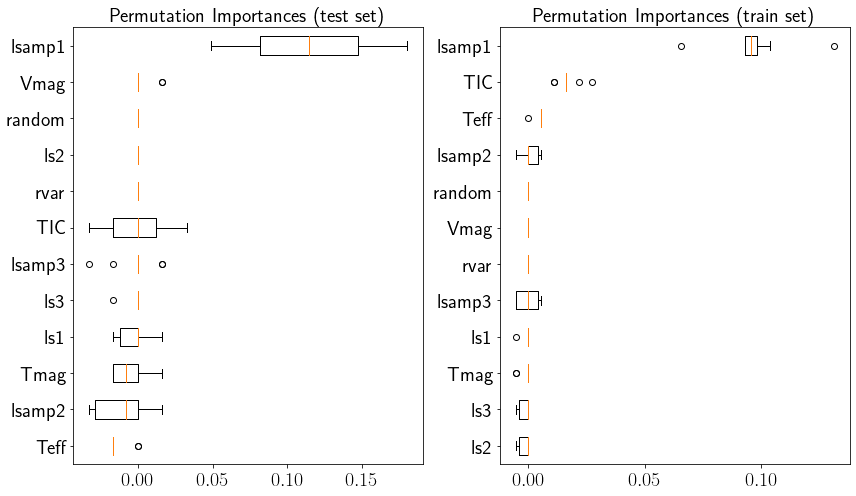

In [27]:
# permutation_importance (one for TRAIN dataset; one for TEST dataset)

result = permutation_importance(rf_model, test_X, test_y, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax1.set_title("Permutation Importances (test set)",fontsize=20)


result2 = permutation_importance(rf_model, X_train, y_train, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx2 = result2.importances_mean.argsort()
ax2.boxplot(result2.importances[sorted_idx2].T,
           vert=False, labels=X_train.columns[sorted_idx2])
ax2.set_title("Permutation Importances (train set)",fontsize=20)

fig.tight_layout()
plt.show()

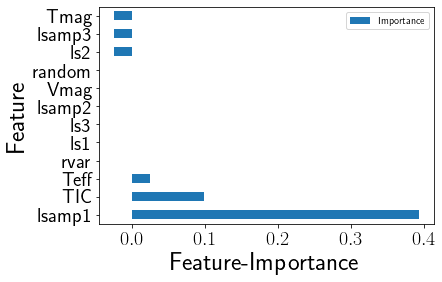

In [28]:
# permutation importance -- a googled way - not sklearn
def r22(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp2 = permutation_importances(rf_model, X_train, y_train, r22)

perm_imp_rfpimp2.plot.barh()
plt.xlabel('Feature-Importance');

Feature ranking:
1. feature 6 (0.256905)
2. feature 8 (0.210829)
3. feature 7 (0.208638)
4. feature 0 (0.149709)
5. feature 9 (0.027747)
6. feature 10 (0.024886)
7. feature 4 (0.024428)
8. feature 5 (0.023623)
9. feature 3 (0.023296)
10. feature 1 (0.021496)
11. feature 2 (0.021223)
12. feature 11 (0.007221)


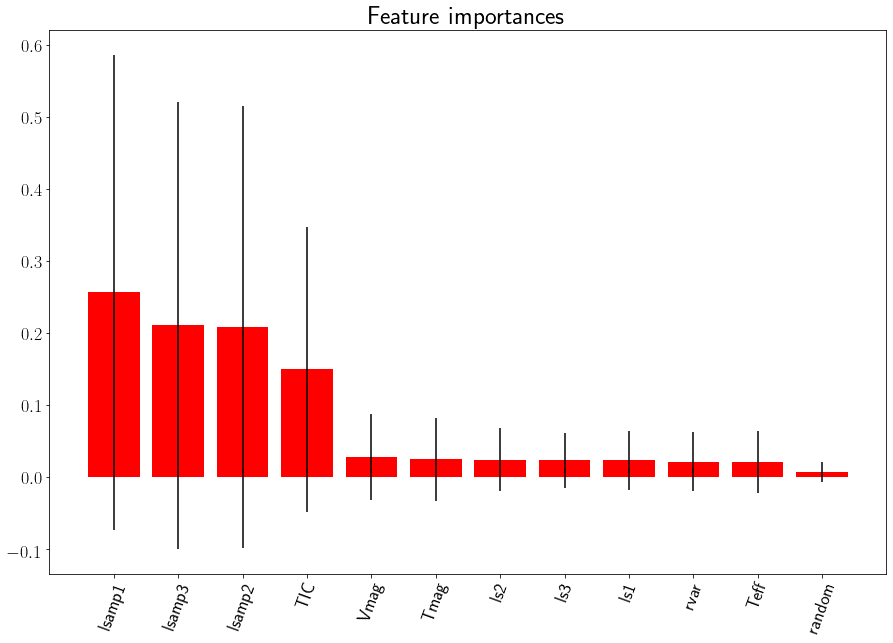

In [29]:
# sklearn - impurity based feature importance (uses training set)

importances2 = rf_model.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances",fontsize=25)
plt.bar(range(X.shape[1]), importances2[indices2],
       color="r", yerr=std2[indices2], align="center")
degrees = 70
plt.xticks(range(X.shape[1]), X.columns[indices2],fontsize=18,rotation=degrees)
plt.xlim([-1, X.shape[1]])
plt.yticks(fontsize=18)
plt.show()

No handles with labels found to put in legend.


lsamp1    0.256905
lsamp3    0.210829
lsamp2    0.208638
TIC       0.149709
Vmag      0.027747
Tmag      0.024886
ls2       0.024428
ls3       0.023623
ls1       0.023296
rvar      0.021496
Teff      0.021223
random    0.007221
dtype: float64


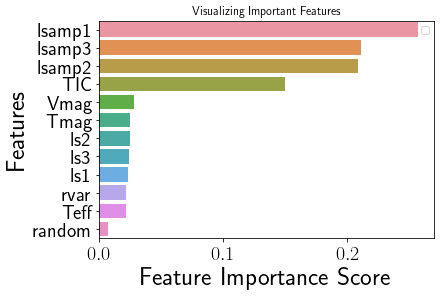

In [30]:
#stsci ds (DSMO) way
feature_imp = pd.Series(rf_model.feature_importances_,index=list(X.columns)).sort_values(ascending=False)
print(feature_imp)
#create a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Make Predictions -----------------------------------
### _first format the unseen data for model_

In [31]:
## prep unseen data for model evaluation

#change colnames to match features in model
unseen_modelprep = unseen_nogiants.rename(columns={'ls-1':'ls1','ls-2':'ls2','ls-3':'ls3','lsamp-1':'lsamp1','lsamp-2':'lsamp2','lsamp-3':'lsamp3'})
#inject random number
np.random.seed(seed = 11)
unseen_modelprep['random'] = np.random.random(size = len(unseen_modelprep))
#select only columns used as features
unseen_features = unseen_modelprep[list(final_features.columns)]
#drop nans
unseen_forRF = unseen_features.dropna()

#make predictions
predictions = rf_model.predict(unseen_forRF)
#add predicted class to df
unseen_forRF['predict_class'] = predictions

unseen_forRF


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,random,predict_class
0,100008376,41.565918,4260.0,5.966919,14.832070,8.408888,0.052525,0.041702,0.040984,12.054,10.94520,0.180270,1
1,100009042,55.823486,5511.0,3.538941,21.453949,5.602844,0.003191,0.002148,0.001386,10.685,9.99362,0.019475,5
2,100009086,300.153516,5507.0,6.478188,10.462729,4.715604,0.833116,0.265699,0.157772,10.446,9.84607,0.463219,1
3,100010226,28.805200,3677.0,4.716485,6.707030,8.349113,0.011895,0.010451,0.006019,13.677,11.82450,0.724934,5
4,100010286,343.870508,4066.0,6.490677,10.919687,4.590450,0.611177,0.411933,0.153213,9.980,8.59030,0.420204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32029,99988654,37.442505,3800.0,5.024283,6.994033,16.953006,0.002814,0.002234,0.001507,12.760,11.05430,0.235376,5
32030,99989665,24.063239,3149.0,3.320681,4.045188,6.437726,0.165936,0.020755,0.016282,16.553,13.51600,0.482773,1
32031,99989903,229.968750,6439.2,2.520679,5.663792,2.258893,0.076863,0.048661,0.046629,7.730,7.28610,0.588894,1
32032,99989956,47.491406,4406.0,12.870381,4.560192,3.696963,0.004423,0.002933,0.001588,11.400,10.40620,0.990865,5


In [32]:
#subselect classes
unseen_periodic = unseen_forRF[unseen_forRF['predict_class']==1] #modulations
unseen_nonperiodic = unseen_forRF[unseen_forRF['predict_class']==5] #flat
print('{} out of {} predicted PERIODIC'.format(len(unseen_periodic),len(unseen_forRF)))
print('{} out of {} predicted NON-PERIODIC'.format(len(unseen_nonperiodic),len(unseen_forRF)))

11807 out of 25780 predicted PERIODIC
13973 out of 25780 predicted NON-PERIODIC


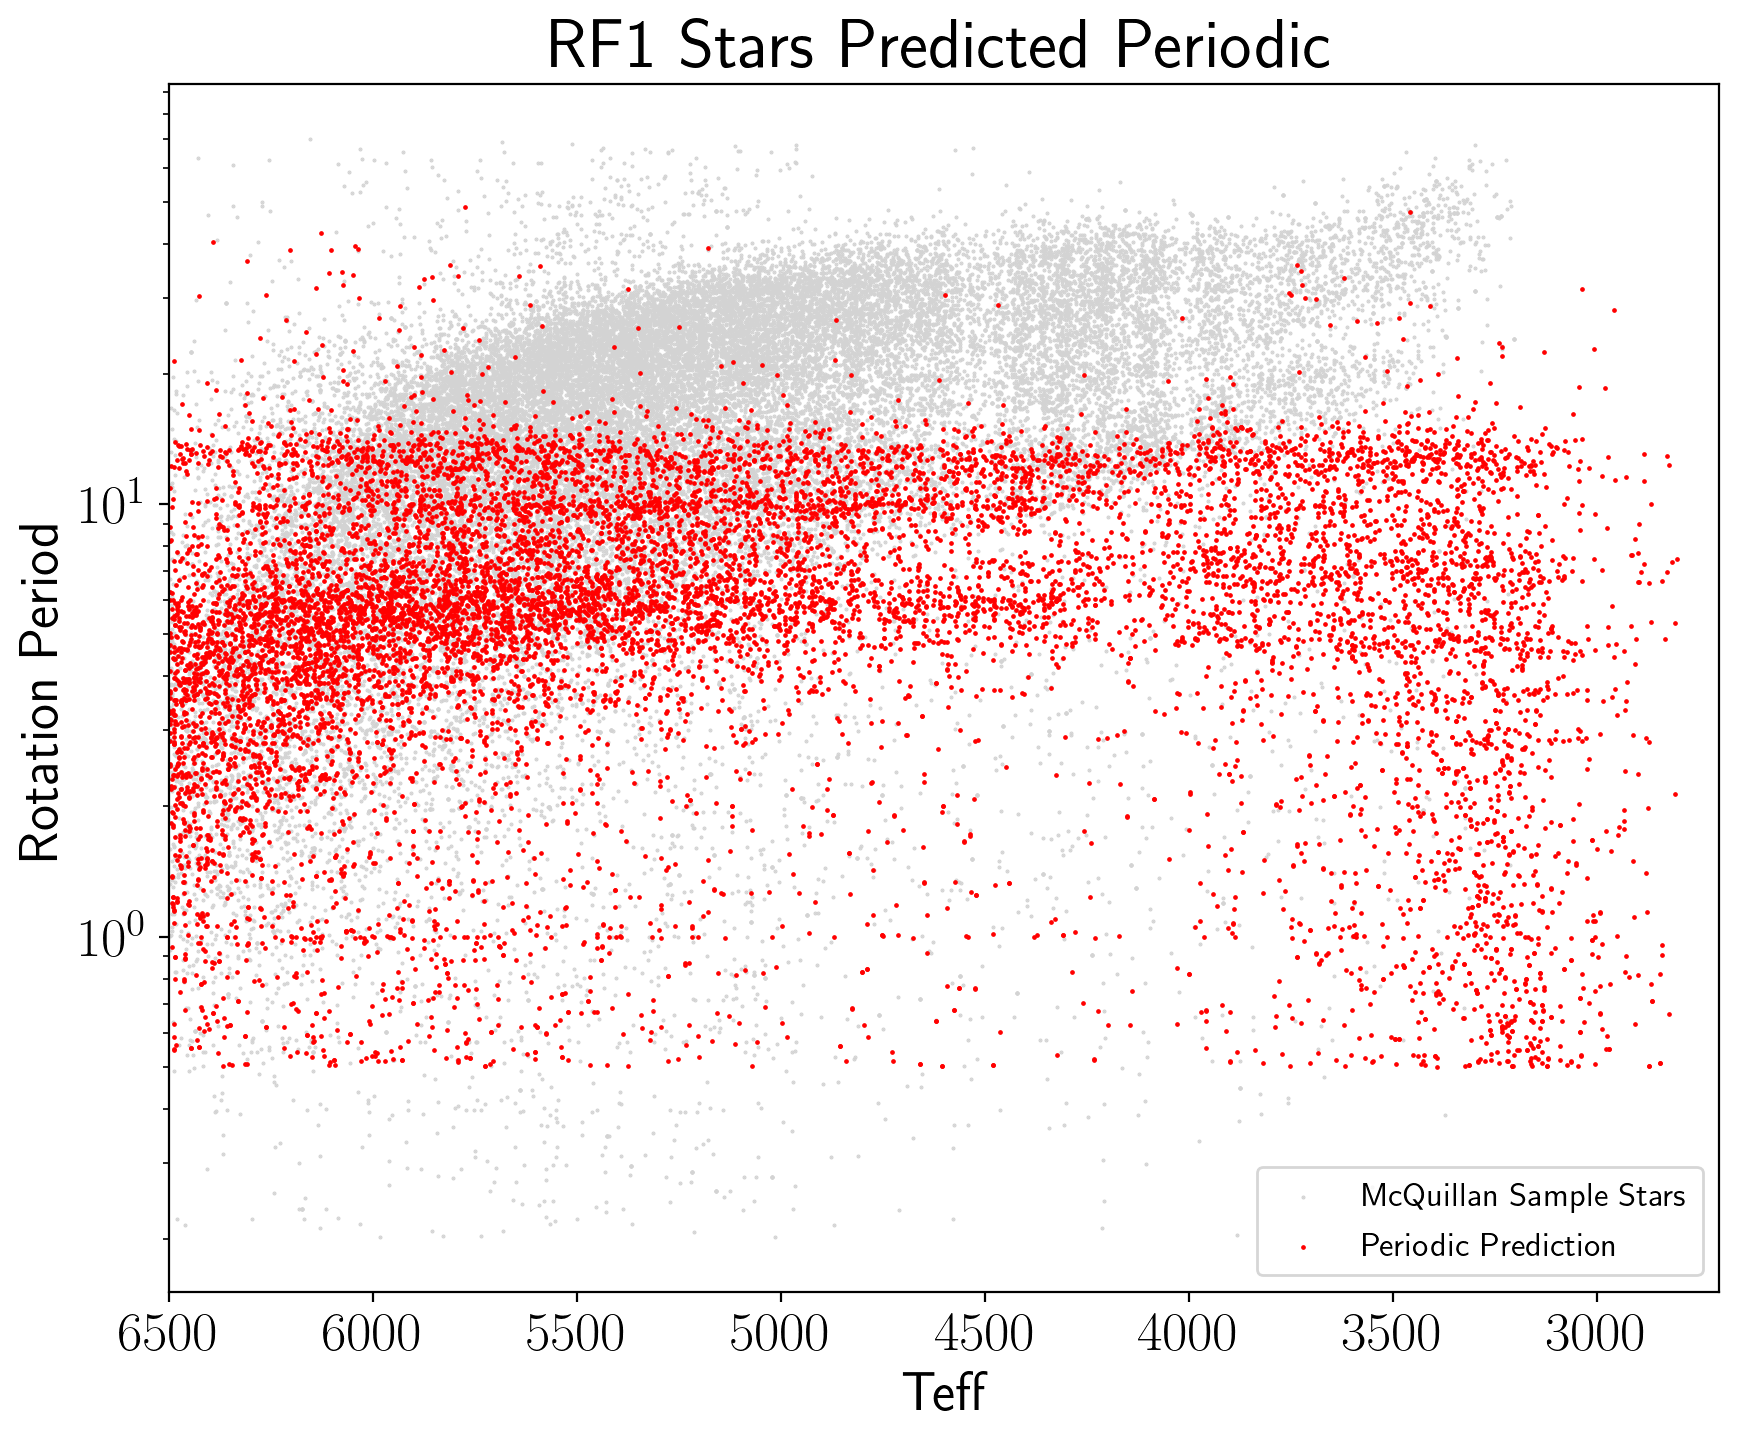

In [33]:
#plot the good predictions over MQ data to see results

plt.figure(figsize=(10,8),dpi=200)
plt.scatter(mqdata['TEMP'].to_numpy(),mqdata['ROTATION_PERIOD'].to_numpy(),s=.2,color='lightgrey',label ='McQuillan Sample Stars')
plt.scatter(unseen_periodic['Teff'].to_numpy(),unseen_periodic['ls1'].to_numpy(),s=.5,color='r',label='Periodic Prediction')
plt.xlim(6500,2700);plt.yscale('log');plt.legend(fontsize='large');plt.title('RF1 Stars Predicted Periodic',fontsize=25);
plt.ylabel('Rotation Period',fontsize=20);plt.xlabel('Teff',fontsize=20);
plt.savefig('data/RF1_results_plot')

## __Below has problems b/c can't match to exact sector....how to get true accuracy??__

In [34]:
#pull out training examples and see how they were predicted

#organize tables needed
truth = short_features
predicted = unseen_forRF[['TIC','predict_class']]
#merge tables to combine data
training_predictions_df = pd.merge(truth,predicted, on=['TIC']) #can't choose sector tho...this could be a problem
print('original training example length', len(truth))


#see how many disagreed
agree = 0
for count,truth in enumerate(training_predictions_df['CLASS'].to_numpy()):
    predicitionarr = training_predictions_df['predict_class'].to_numpy()
    predicted = predicitionarr[count]
    if truth == predicted:
        agree += 1
    else:
        pass
print('{} accurate out of {}'.format(agree, len(training_predictions_df)))
print('{} accuracy'.format((agree / len(training_predictions_df))*100))

training_predictions_df

original training example length 244
121 accurate out of 131
92.36641221374046 accuracy


,TIC,rvar,Teff,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,Vmag,Tmag,CLASS,random,predict_class
0,102903938,1690.382324,6252.00,15.179791,6.744649,3.622451,0.482339,0.307881,0.147394,10.04700,9.56664,1,0.454198,1
1,102928809,3636.038281,6281.12,0.793073,0.760976,0.827820,0.991467,0.073892,0.058097,7.82000,7.34061,1,0.478257,1
2,153975515,2100.355566,6077.00,34.448441,9.119487,5.396309,0.868915,0.078332,0.029835,10.18000,9.52407,5,0.915503,1
3,153975515,2100.355566,6077.00,34.448441,9.119487,5.396309,0.868915,0.078332,0.029835,10.18000,9.52407,5,0.915503,1
4,154089472,2838.096875,5491.00,13.716268,6.474866,3.889126,0.858537,0.092611,0.008217,8.45000,7.78390,1,0.355830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,230077650,2942.876562,6146.24,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,7.52000,7.01450,1,0.433992,1
127,230085290,3277.640625,5767.89,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,7.11438,6.51920,1,0.937504,1
128,230085290,3277.640625,5767.89,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,7.11438,6.51920,1,0.937504,1
129,53569838,5909.745313,5212.00,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,8.14000,7.45140,1,0.593216,1


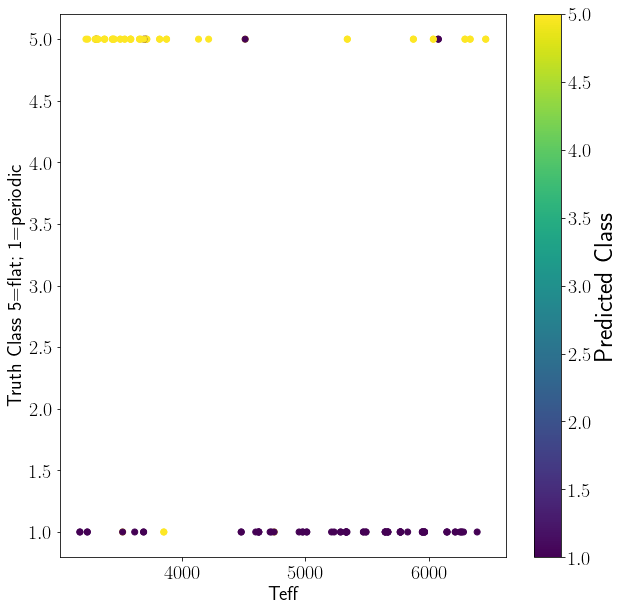

In [35]:
#plot prediciton vs truth

plt.figure(figsize=(10,10))
plt.scatter(training_predictions_df['Teff'].to_numpy(),training_predictions_df['CLASS'].to_numpy(), c=training_predictions_df['predict_class'].to_numpy())
# plt.scatter(xs,ys,label='OnetoOne line');
plt.colorbar().set_label('Predicted Class');
plt.xlabel('Teff',fontsize=20); plt.ylabel('Truth Class 5=flat; 1=periodic',fontsize=20);

In [36]:
# plot general distributions of results for good predictions only

In [37]:
print('{} Periodic Stars out of {} Light Curves --note could be same star observed in both sectors'.format(len(unseen_periodic),len(unseen)))

11807 Periodic Stars out of 32035 Light Curves --note could be same star observed in both sectors


In [38]:
# explore distribution of training examples
# f, ax = plt.subplots(7,2,figsize=(18,15))
# for count,col in enumerate(list(unseen_periodic.columns)):
#     if count <6: #count % 2 ==False: #even
# #         print('if:',col,count)
#         ax[count,0].hist(unseen_periodic[col].to_numpy())
#         ax[count,0].set_title(col,fontsize=15)
#     else: #odd
# #         print('else:',col,count)
#         ax[count-6,1].hist(unseen_periodic[col].to_numpy())
#         ax[count-6,1].set_title(col,fontsize=15)
# plt.tight_layout()

In [39]:
#saving dfs for RF2

# save "Periodic" predicitions to advance to RF2------already ran!
# unseen_periodic.to_csv('data/RF1_results.csv',index=False)

# save unseen data that has had giants removed-----already ran!
# unseen_nogiants.to_csv('data/allstats_secs14_15_nogiants.csv',index=False)

# save features & labels with all stats (including relics from finding examples) with GIANTS removed! ----already ran!
# features_nogiants.to_csv('data/RF1_TrainingSet_nogiants.csv', index = False)

In [40]:
features_nogiants

,TIC,TOTsecs,rvar,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,acf1,...,depth,transit_time,duration,CLASS,LS_correct,ACF_correct,ACF2_correct,# comments,Sector,GAIA_AbsMag
14,38907305,13.0,0.004499,1.288280,1.293625,1.284414,0.018083,0.018049,0.017965,0.780556,...,0.007053,17.776,0.16,5,NaN,NaN,NaN,NaN,NaN,33.168263
19,139371600,13.0,0.004312,4.405840,4.768137,4.123799,0.013442,0.009037,0.007418,0.069445,...,0.000049,8.816,0.16,1,1.0,0.0,1.0,# acf2 differs by ~0.2,NaN,34.018541
20,140579537,13.0,0.011740,5.511737,11.058362,6.093628,0.134257,0.092020,0.050129,0.069445,...,0.000201,15.520,0.16,1,1.0,0.0,0.0,NaN,NaN,35.244698
21,140579674,13.0,0.015263,2.247234,6.658397,6.978570,0.196899,0.070410,0.069368,0.069445,...,0.000289,18.816,0.16,1,0.0,0.0,0.0,"# ls2 is correct, acf2 is a double harmonic",NaN,35.938339
22,140580497,13.0,0.014146,10.264962,9.369888,10.688587,0.000516,0.000505,0.000330,0.069445,...,0.000404,4.192,0.16,5,NaN,NaN,NaN,NaN,NaN,40.386893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,230077650,NaN,2942.876562,4.139007,2.161909,5.357952,0.785663,0.167051,0.080532,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,34.181664
73,230085290,NaN,3277.640625,6.277685,10.169879,2.887609,0.571070,0.164300,0.163476,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,34.187942
74,47579336,NaN,12540.856250,3.864723,3.121786,5.063066,0.973883,0.222684,0.219672,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,36.500925
75,53569838,NaN,5909.745313,7.308811,18.858413,5.054958,0.289424,0.171771,0.123088,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,15.0,35.682523
